## Motivation
### The drawbacks of simply increasing the network size
Increasing the depth and the width of a deep neural network is an easy way to improve its performance. But the enlarged deep neural network will be:
- **prone to overfitting** with a large number of parameters to train, especially when the training dataset size is limited.
- **computationally expensive**. If most weights end up to be close to zero, then much of the computation resources is wasted.

### Inspiration
1. The Hebbian principle: neurons fire together, wire together.
    This principle suggests that the **connections between neurons should be sparse rather than dense**.
2. The work by Arora et al. states that "if the probability distribution of the dataset is representable by a large, very sparse deep neural network, then the optimal network topology can be constructed layer by layer by analyzing the correlation statistics of the activations of the last layer and clustering neurons with highly correlated outputs."
    **This shows that we may construct a sparse network with dense components.**
3. For computer vision tasks, it is usually benefitial to utalize multi-scale features. 

### Goal
Current machine learning architectures are not suitable for arithmetic calculations on ununiform sparce matrices. "This raises the question whether there is any hope for a next, intermediate step: **an architecture that makes use of the extra sparsity, even at filter level, but exploits our current hardware by utilizing computations on dense matrices**.

This paper is a case study that **"tries to approximate a sparse structure for vision networks" with "dense, readily available components"**.

## The Inception Module
One inception module is usually composed of several covolutional filters of different sizes and a pooling layer.

### The naive version of the inception module
The naive version of an inception module is shown as below:
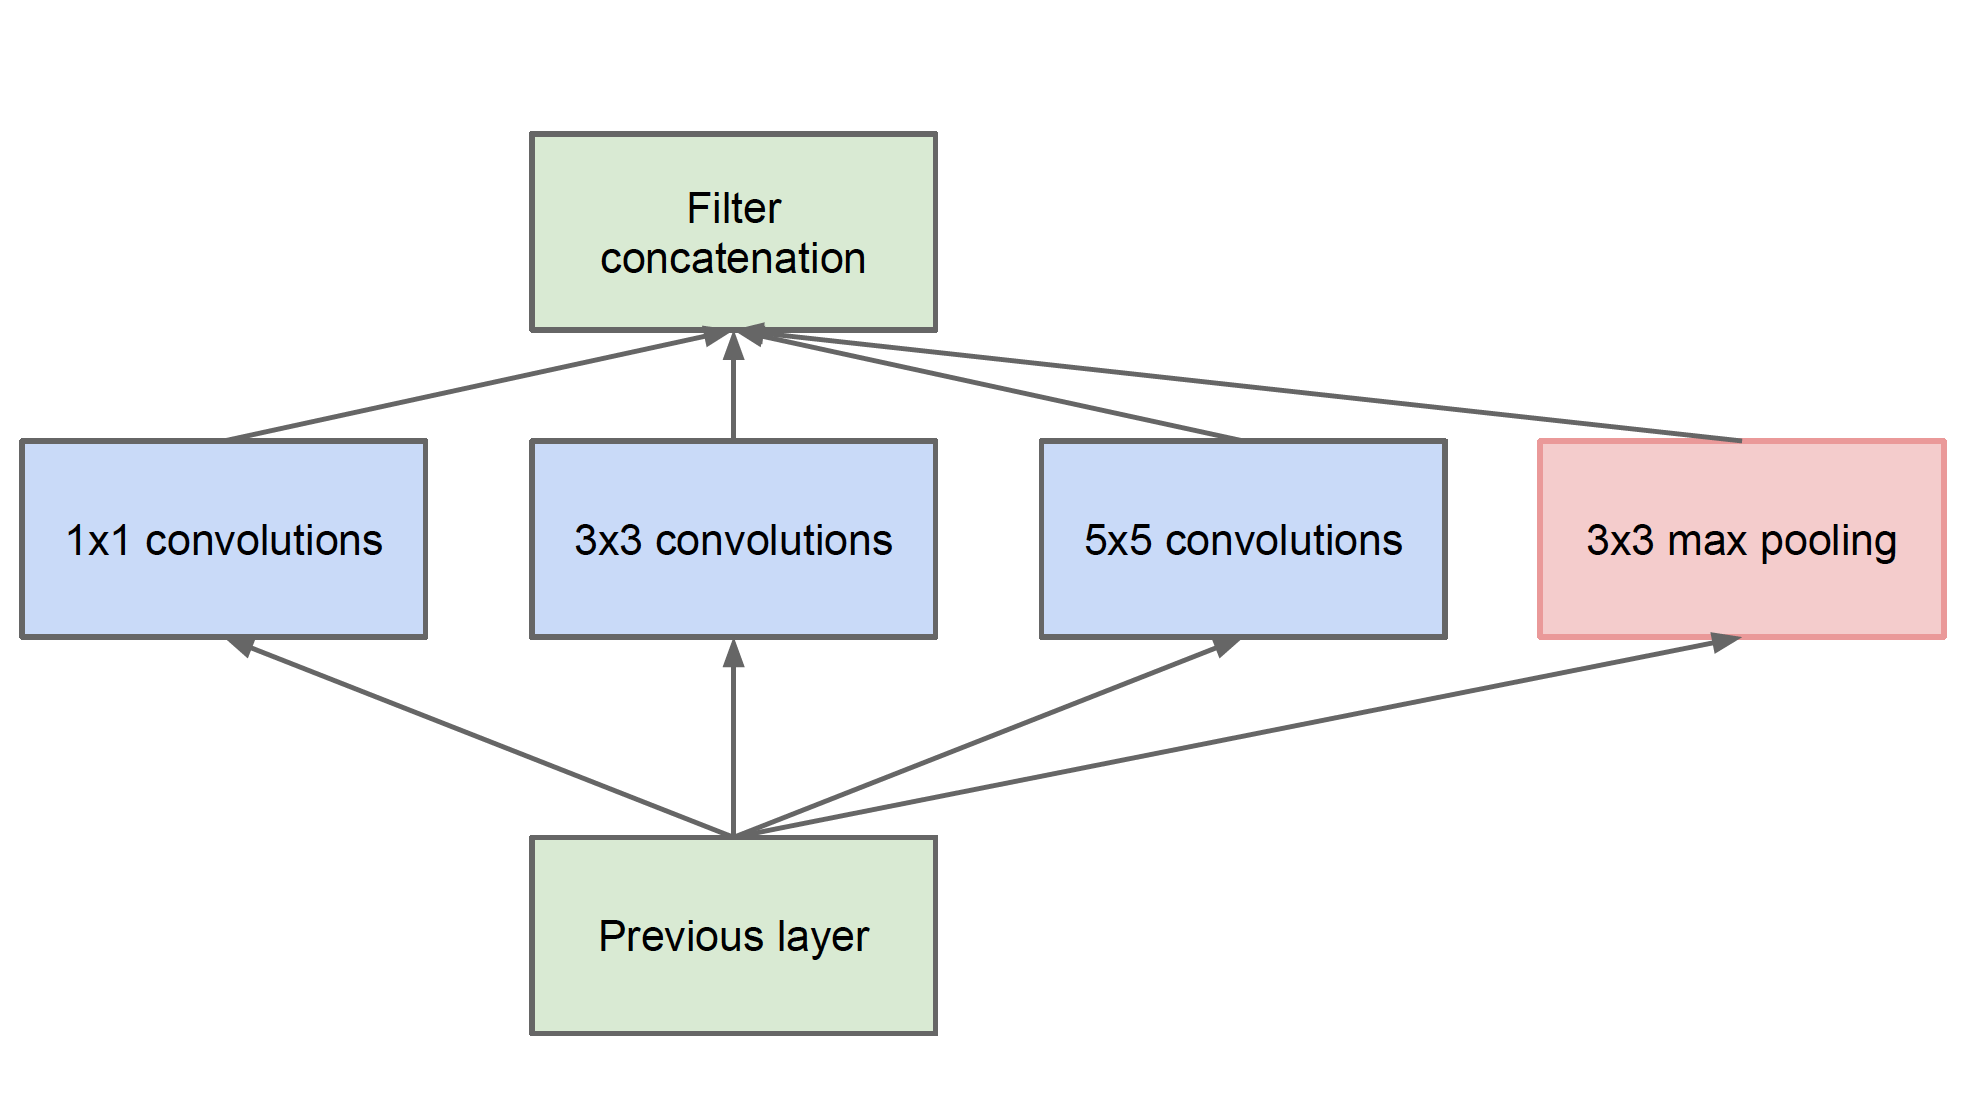
 

In this naive version, the output of the previous layer is passed into an $1\times 1$ covultional layer, a $3 \times 3$ convolutinal layer, a $5 \times 5$ convolutional layer and a $3 \times 3$ max pooling layer in parallel. And then they are concaternated along the channels.

Here are the keypoints:
1. Different kernel sizes means multi-scale features and different receptive fields. And the concaternation is fusing those features together. This feature fusion usually benefit computer vision tasks;
2. The kernal sizes 1, 3, 5 are for convenience to align the output sizes. With paddings of 0, 1, 2 and stride 1, the output size will be the same.
3. As features of higher abstraction are captured by higher layers, the spacial concentration is expected to decrease, suggesting that the ratio of $2 \times 3$ and $5 \times 5$ convolutions should increase as we move to higher layers.

### Inception module

The smaller the kernel size is, the sparser the convolutional layer will be, and the less parameters the layer will have. The $5 \times 5$ convolutional layers will cost plenty of computation resources. If the $5 \times 5$ convolutional layer has the same number of filters as the $1 \times 1$ convolutional layer, it will need 25 times multiplications as the $1 \times 1$ convolutional layer.

Further more, we have a concaternation at the end of the inception layer, which concaternates all the convolutional outputs together with the maxpooling output. As we all know the maxpooling layer won't change the channel size of the input, which means after the concaternation, there will be an increasing the chanel dimension of the output. And this situation together with the $5 \times 5$ kernel size will need an exploding computing resources. 

To deal with this, in the formal inception module, for each convolutional layer (except the $1 \times 1$ layer) and the maxpooling layer, additional $1 \times 1$ convolutional layers are added for dimension reduction.

Below is the architecture of the inception module:
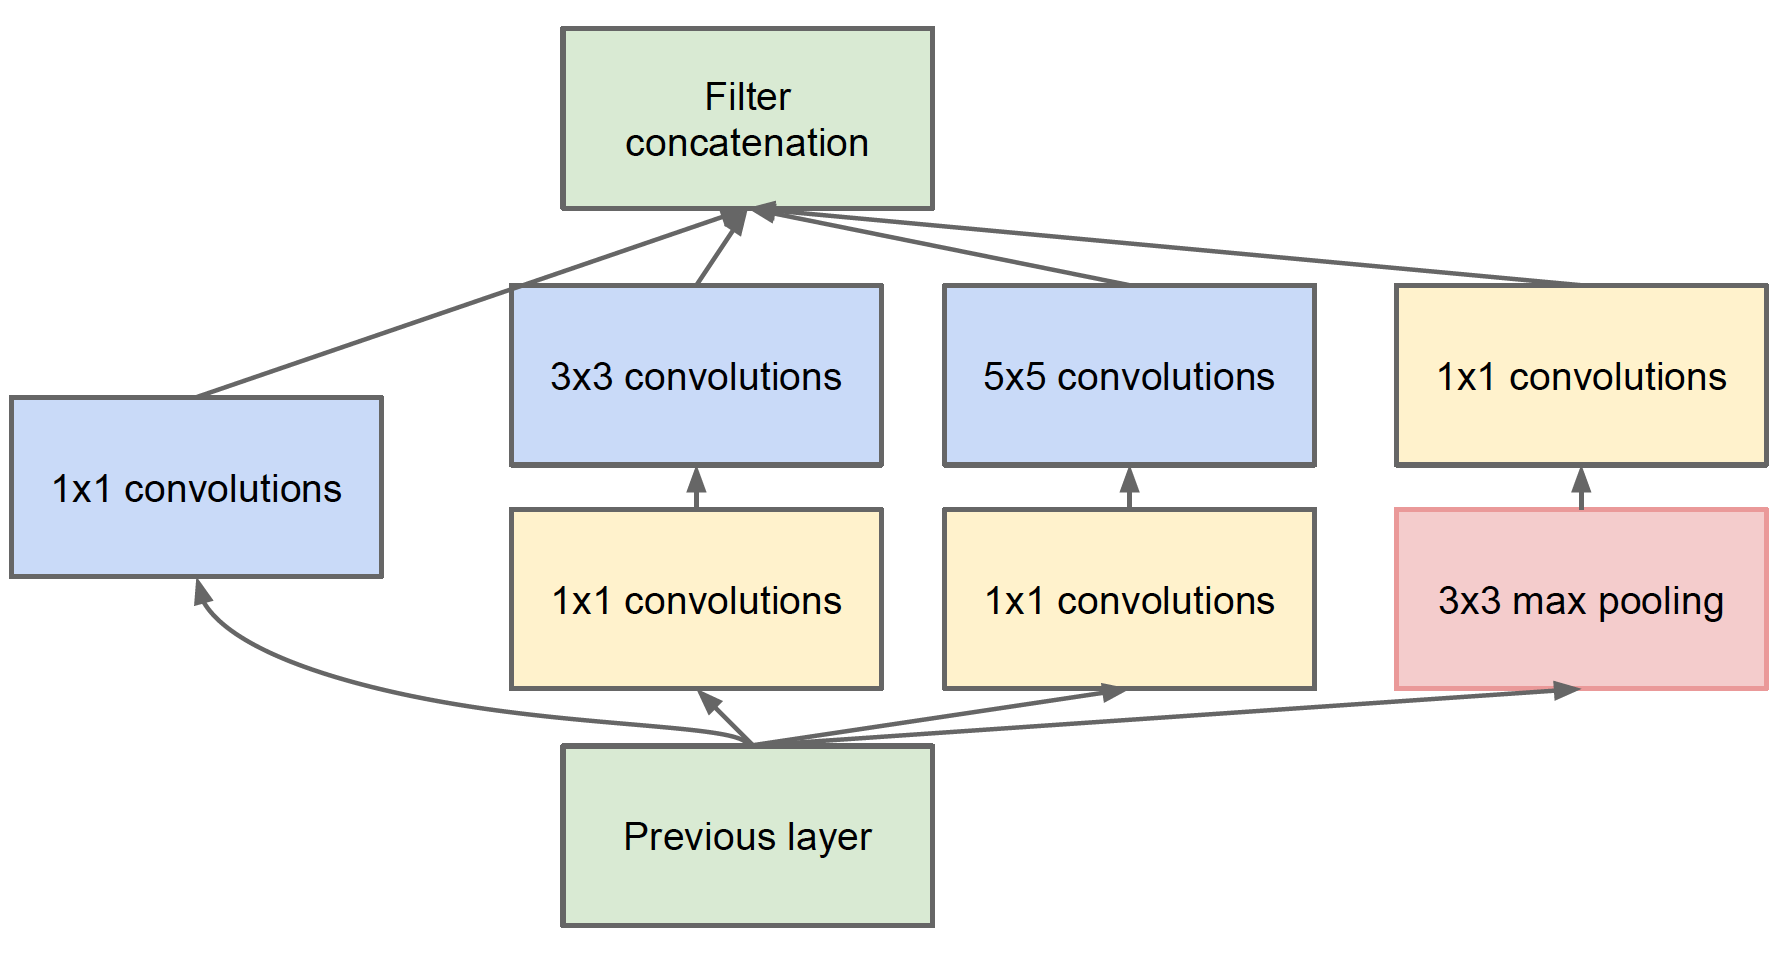

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__()
        # path1 is a single 1 by 1 convolution
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        
        # path2 is an 1 by 1 convolution following an 3 by 3 convolution
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        
        # path3 is an 1 by 1 ocnvulution following an 5 by 5 convolution
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        # path4 is an 3 by 3 maxpooling following an 1 by 1 convolution
        self.p4_1 = nn.MaxPool2d( stride=1, kernel_size=3, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4), dim=1)        

## GoogLeNet
For simplicity, we will just introduce an simplified version of GoogLeNet, which is stacked by 9 Inception modules. MaxPooling layers are inserted between these Inception modules to reduce resolution (dimensionality).

The whole architecture is as below:
![](inception-full.svg)

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, padding=1, stride=2))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [4]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## Dataset

In [14]:
import sys
sys.path.append("../dlutils")
from dataset import load_fashion_mnist_dataset

train_loader, test_loader = load_fashion_mnist_dataset(batch_size=128, resize=96)

## Loss

In [15]:
loss = nn.CrossEntropyLoss()

## Optimizer

In [16]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

## Training

In [18]:
from train import train_3ch

num_epochs =50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss.to(device)

train_3ch(net, loss, num_epochs, train_loader, optimizer, test_loader, device)

epoch 0, training loss 0.018008, training accuracy 0.100000, testing loss 0.018201, testing accuracy 0.100000
epoch 1, training loss 0.018013, training accuracy 0.100000, testing loss 0.018205, testing accuracy 0.100000
epoch 2, training loss 0.018010, training accuracy 0.100000, testing loss 0.018202, testing accuracy 0.100000
epoch 3, training loss 0.018004, training accuracy 0.100000, testing loss 0.018195, testing accuracy 0.100000
epoch 4, training loss 0.018010, training accuracy 0.100000, testing loss 0.018201, testing accuracy 0.100000
epoch 5, training loss 0.018020, training accuracy 0.100000, testing loss 0.018213, testing accuracy 0.100000
epoch 6, training loss 0.018002, training accuracy 0.100000, testing loss 0.018194, testing accuracy 0.100000
epoch 7, training loss 0.018013, training accuracy 0.100000, testing loss 0.018205, testing accuracy 0.100000
epoch 8, training loss 0.018005, training accuracy 0.100000, testing loss 0.018196, testing accuracy 0.100000
epoch 9, t